# Cloud Optimization Tests
## Downscaling MUR SST using AWS EC2

See how long it takes to downscale an ultra-high resolution SST product when accessing an SST file on AWS S3 ***using dask***. Downscale from 0.01 degree resolution to 1 deg resolution (global coverage).

Uses the MUR Level 4 daily SST ultra high resolution data product, 0.01 degree resolution, s3 location `s3://podaac-ops-cumulus-protected/MUR-JPL-L4-GLOB-v4.1/`.

<br>

**Requirements to run this notebook**
* Have a URS Earthdata login.
* Run in an AWS EC2 instance (minimum without dask chuncking is a t2.xlarge instance).
* Have URS Earthdata login credentials in the `.netrc` file on the home directory:
```
machine urs.earthdata.nasa.gov
    login <Earthdata username>
    password <Earthdata password>
```

<br>

**Current Status**
* Seems like a minimum of a t2.xlarge instance (8 GB RAM) is required.
* ***Garbage collection and variable deletion is essential. EC2 instance runs out of RAM otherwise.***

<br>

**To do**
* Try to load file with xarray using the `chunks` argument.

In [66]:
import gc
import os
import time

import s3fs
import requests

import xarray as xr
import h5py
import numpy as np
import pandas as pd

import dask.array as da
from dask.distributed import Client, LocalCluster, progress
from dask import delayed

import matplotlib.pyplot as plt
%matplotlib inline

## Function to set up an s3fs session for Direct Access 
If the following function fails, verify that the following is in the .netrc file in your home directory:
```
machine urs.earthdata.nasa.gov
    login <Earthdata username>
    password <Earthdata password>
```
where the `<Earthdata username>` and `<Earthdata password>` are your login credentials.

In [67]:
def init_S3FileSystem():
    """
    This routine automatically pulls your EDL crediential from .netrc file and use it 
    to obtain a temporary AWS S3 credential through a podaac service accessable at 
    https://archive.podaac.earthdata.nasa.gov/s3credentials
    
    Return:
    =======
    s3: an AWS S3 filesystem
    """
    import requests,s3fs
    creds = requests.get('https://archive.podaac.earthdata.nasa.gov/s3credentials').json()
    s3 = s3fs.S3FileSystem(anon=False,
                           key=creds['accessKeyId'],
                           secret=creds['secretAccessKey'], 
                           token=creds['sessionToken'],
                           client_kwargs={'region_name':'us-west-2'})
    return s3

## Functions to load and downscale MUR SST files

In [61]:
def downscale_xr_s3(fs_s3, filepath_s3, output_dir, chunks=None):
    """
    Open and downscale SST's from 1 km to 100 km from a MUR 1 km file on an S3 bucket. fs_s3 is the 
    S3 file system and filepath_s3 is the MUR filepath on S3. output_dir is the directory to save 
    the downscaled data file in.
    """
    
    print('Opening ', filepath_s3)
    s3_file_obj = fs_s3.open(filepath_s3, mode='rb')
    sstdata = xr.open_dataset(s3_file_obj, chunks=chunks)
    
    def downscale_mursst(sst):
        """
        This function takes MUR SST 1km data (with dimensions of 17900x36000), reshapes, and 
        computes the mean temperature in 1x1 degree boxes, and then returns the processed 
        SST data (shape 180x360).

        Parameters
        ----------
        sst: 2D array-like of sea surface temperatures.
        """
        sst0 = np.r_[sst[0:1, :], sst]; del sst
        sst = sst0.reshape(180, 100, 360, 100).mean(axis=-1).mean(axis=1); del sst0
        return sst
    
    print("Downscaling.")
    sst_downscaled = downscale_mursst(sstdata['analysed_sst'][0, ...])
    
    # Save downscaled SST to .nc file:
    print("Saving output.")
    ds = xr.Dataset(
        data_vars=dict(
            sst=(["time", "lat", "lon"], np.expand_dims(sst_downscaled, axis=0)) # Add dim for time.
            ),
        coords=dict(
            lon=sstdata['lon'].values[::100], # lons, lats in downscaled res.
            lat=sstdata['lat'].values[::100],
            time=sstdata["time"].values,
            ),
        attrs=dict(
            description="SST downscaled from MUR 1 km file to 100 km resolution.",
            units="K",
            ),
        )
    ds.to_netcdf(output_dir + filepath_s3.split("/")[-1][:-3] + "_downscaled.nc")
    
    sstdata.close()

In [62]:
def downscale_xr_local(filepath, output_filepath, chunks=None):
    """
    Open and downscale SST's from 1 km to 100 km from a MUR 1 km file from a local machine. 
    filepath is the MUR filepath. output_dir is the directory to save 
    the downscaled data file in.
    """
    
    print('Opening ', filepath)
    sstdata = xr.open_dataset(filepath, chunks=chunks)
    
    def downscale_mursst(sst):
        """
        This function takes MUR SST 1km data (with dimensions of 17900x36000), reshapes, and 
        computes the mean temperature in 1x1 degree boxes, and then returns the processed 
        SST data (shape 180x360).

        Parameters
        ----------
        sst: 2D array-like of sea surface temperatures.
        """
        sst0 = np.r_[sst[0:1, :], sst]; del sst
        sst = sst0.reshape(180, 100, 360, 100).mean(axis=-1).mean(axis=1); del sst0
        return sst
    
    print("Downscaling.")
    sst_downscaled = downscale_mursst(sstdata['analysed_sst'][0, ...])
    
    # Save downscaled SST to .nc file:
    print("Saving output.")
    ds = xr.Dataset(
        data_vars=dict(
            sst=(["time", "lat", "lon"], np.expand_dims(sst_downscaled, axis=0)) # Add dim for time.
            ),
        coords=dict(
            lon=sstdata['lon'].values[::100], # lons, lats in downscaled res.
            lat=sstdata['lat'].values[::100],
            time=sstdata["time"].values,
            ),
        attrs=dict(
            description="SST downscaled from MUR 1 km file to 100 km resolution.",
            units="K",
            ),
        )
    ds.to_netcdf(output_filepath)
    
    sstdata.close()

## Establish S3 Connection and Get MUR File Paths to Downscale

In [68]:
# Get temporary AWS credentials for access
fs_s3 = init_S3FileSystem()

KeyError: 'accessKeyId'

In [25]:
# File paths of all MUR granules:
s3path = "s3://podaac-ops-cumulus-protected/MUR-JPL-L4-GLOB-v4.1/"
fns = fs_s3.glob(s3path+"*.nc")
print("total granules = ",len(fns))
print("Example filename: ", fns[0])

total granules =  7664
Example filename:  podaac-ops-cumulus-protected/MUR-JPL-L4-GLOB-v4.1/20020601090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1.nc


In [26]:
if not os.path.isdir("./sst_downscaled"):
    os.mkdir("./sst_downscaled")

In [59]:
%%time
downscale_xr_s3(fs_s3, fns[0], "./sst_downscaled/")

Opening  podaac-ops-cumulus-protected/MUR-JPL-L4-GLOB-v4.1/20020601090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1.nc
Downscaling.
Saving output.
CPU times: user 12.4 s, sys: 4.12 s, total: 16.5 s
Wall time: 27.7 s


In [56]:
%%time
fname_local = "20210101090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1.nc"
downscale_xr_local(fname_local, "./sst_downscaled/" + fname_local)

Opening  20210101090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1.nc
Downscaling.
Saving output.
CPU times: user 8.95 s, sys: 2.91 s, total: 11.9 s
Wall time: 11.9 s


In [65]:
%%time
fname_local = "20210101090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1.nc"
downscale_xr_local(fname_local, "./sst_downscaled/" + fname_local, chunks='auto')

Opening  20210101090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1.nc
Downscaling.
Saving output.
CPU times: user 11.8 s, sys: 3.61 s, total: 15.4 s
Wall time: 10.6 s


In [64]:
%%time
downscale_xr_s3(
    fs_s3, fns[0], "./sst_downscaled/", 
    #chunks={'time':1, 'lat':int(17999/3), 'lon':int(36000/3)}
    chunks='auto'
    )

Opening  podaac-ops-cumulus-protected/MUR-JPL-L4-GLOB-v4.1/20020601090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1.nc
Downscaling.
Saving output.
CPU times: user 17.6 s, sys: 4.45 s, total: 22 s
Wall time: 22.8 s


## Setup Dask

In [9]:
# Detect available vCPUs on this machine:
import multiprocessing
n_workers = multiprocessing.cpu_count()
print(n_workers)

4


In [11]:
#client = Client('tcp://127.0.0.1:36921')
client = Client(n_workers=n_workers)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 4,Total memory: 15.61 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:35255,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 4
Started: Just now,Total memory: 15.61 GiB
Comm: tcp://127.0.0.1:42353,Total threads: 1
Dashboard: http://127.0.0.1:43095/status,Memory: 3.90 GiB
Nanny: tcp://127.0.0.1:40985,


In [1]:
client.close()

NameError: name 'client' is not defined

In [ ]:
#s3_file_obj = fs_s3.open(fns[0], mode='rb')
#test = xr.load_dataset(s3_file_obj, chunks={'lat': 25, 'lon': 25, 'time': -1})

In [63]:
A = client.map(load_file, [fs_s3], fns_downscale[0])
test = client.submit(downscale_mursst, A)
#client.submit()

In [64]:
#test = client.submit(load_file, fs_s3, fns_downscale[0])

In [19]:
#test.result()

Exception ignored in: <function Client.__del__ at 0x7f67b27a4ef0>
Traceback (most recent call last):
  File "/home/ec2-user/conda/envs/jupyter/lib/python3.7/site-packages/distributed/client.py", line 1190, in __del__
    self.close()
  File "/home/ec2-user/conda/envs/jupyter/lib/python3.7/site-packages/distributed/client.py", line 1401, in close
    if self.asynchronous:
  File "/home/ec2-user/conda/envs/jupyter/lib/python3.7/site-packages/distributed/client.py", line 813, in asynchronous
    return self._asynchronous and self.loop is IOLoop.current()
AttributeError: 'Client' object has no attribute '_asynchronous'


In [18]:
# Wrap the function with dask.delayed
delayed_load_and_downscale = delayed(load_and_downscale)
# Process all granules in parallel using Dask
results = [delayed_load_and_downscale(fs_s3, [fp]) for fp in fns_downscale]

In [19]:
test = da.compute(*results)

distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 2.99 GiB -- Worker memory limit: 3.90 GiB
distributed.worker - WARNING - Worker is at 90% memory usage. Pausing worker.  Process memory: 3.53 GiB -- Worker memory limit: 3.90 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 3.53 GiB -- Worker memory limit: 3.90 GiB
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Restarting worker
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.

KilledWorker: ('load_and_downscale-5fe75ff1-15dc-4bf8-8c20-cccc54625d3e', <WorkerState 'tcp://127.0.0.1:35101', name: 3, status: closed, memory: 0, processing: 1>)

## Test new function with timekeeping built in

In [13]:
# Get temporary AWS credentials for access
fs_s3 = init_S3FileSystem()

In [7]:
# File paths of all MUR granules:
s3path = "s3://podaac-ops-cumulus-protected/MUR-JPL-L4-GLOB-v4.1/"
fns = fs_s3.glob(s3path+"*.nc")
print("total granules = ",len(fns))
print("Example filename: ", fns[0])

total granules =  7636
Example filename:  podaac-ops-cumulus-protected/MUR-JPL-L4-GLOB-v4.1/20020601090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1.nc


In [27]:
# Run downscale for all or a subset of the MUR files:
fns_downscale = fns[:200] # Files to downscale.
exectimes = load_and_downscale(fs_s3, fns_downscale)

Loading file number  1 :  podaac-ops-cumulus-protected/MUR-JPL-L4-GLOB-v4.1/20020601090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1.nc
Downscaling.
Loading file number  2 :  podaac-ops-cumulus-protected/MUR-JPL-L4-GLOB-v4.1/20020602090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1.nc
Downscaling.
Loading file number  3 :  podaac-ops-cumulus-protected/MUR-JPL-L4-GLOB-v4.1/20020603090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1.nc
Downscaling.
Loading file number  4 :  podaac-ops-cumulus-protected/MUR-JPL-L4-GLOB-v4.1/20020604090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1.nc
Downscaling.
Loading file number  5 :  podaac-ops-cumulus-protected/MUR-JPL-L4-GLOB-v4.1/20020605090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1.nc
Downscaling.
Loading file number  6 :  podaac-ops-cumulus-protected/MUR-JPL-L4-GLOB-v4.1/20020606090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1.nc
Downscaling.
Loading file number  7 :  podaac-ops-cumulus-protected/MUR-JPL-L4-GLOB-v4.1/20020607090000-JPL-L4_GH

In [28]:
print(timekeep)

[49.10705304145813, 44.40025305747986, 43.535573959350586, 42.30505728721619, 46.91578006744385, 42.78103232383728, 42.33134913444519, 47.5928750038147, 47.1717414855957, 49.991981506347656, 43.99895405769348, 43.03749918937683, 47.47716808319092, 47.988789081573486, 46.67377042770386, 46.58236074447632, 41.95031666755676, 44.268667221069336, 44.49359941482544, 47.87984895706177, 42.20066046714783, 46.10789155960083, 42.14349937438965, 42.53711295127869, 43.20109295845032, 43.25973081588745, 47.1577684879303, 45.92064309120178, 46.943493604660034, 45.7447874546051, 43.10818600654602, 47.09110999107361, 46.226802349090576, 44.4386727809906, 42.284015417099, 43.11628341674805, 42.60962891578674, 47.46752214431763, 42.809688329696655, 45.06207060813904, 43.86503601074219, 41.59354019165039, 43.086119651794434, 42.659523248672485, 47.408276319503784, 47.8544647693634, 48.3838996887207, 44.18834090232849, 47.595393896102905, 48.06768202781677, 44.88863825798035, 43.92991852760315, 45.986932

In [29]:
exectimes = timekeep

## Save execution time results to .csv

In [31]:
# Compute total execution time as a function of files processed:
exectimes_total = []
exectimes_total.append(exectimes[0])
for i in range(1, len(exectimes)):
    exectimes_total.append(exectimes_total[i-1] + exectimes[i])

In [49]:
# Store results in a pandas DataFrame:
filenum = range(1, len(fns_downscale)+1)
exectimes_df = pd.DataFrame({
    'Total_Files_Downscaled': filenum, 
    'Total_Execution_Time_Seconds': exectimes_total
    })

In [50]:
# Save
insttype = !ec2-metadata | grep "instance-type" # get EC2 type for filename
insttype = insttype[0][15:]
fname_save = "execution_times_" + insttype + ".csv"
exectimes_df.to_csv(fname_save, index=False)

## Plot results

Text(0, 0.5, 'Total Execution Time (minutes)')

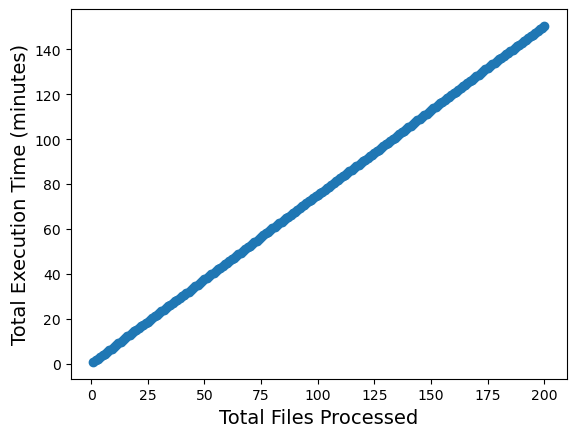

In [52]:
plt.figure()
plt.plot(
    exectimes_df['Total_Files_Downscaled'], 
    exectimes_df['Total_Execution_Time_Seconds']/60, 
    'o-'
    )
plt.xlabel("Total Files Processed", fontsize=14)
plt.ylabel("Total Execution Time (minutes)", fontsize=14)

## Processing time for 1, 5, 20, 50 files

In [6]:
filenums = [1, 5, 20, 50]
exectimes = []

In [12]:
# 1 file:
tstart = time.time() # tick
load_and_downscale(fns[:filenums[0]])
tend = time.time() # tick

Loading  podaac-ops-cumulus-protected/MUR-JPL-L4-GLOB-v4.1/20020601090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1.nc
Downscaling.


In [13]:
exectimes.append(tend - tstart)

In [14]:
# 5 files:
tstart = time.time() # tick
load_and_downscale(fns[:filenums[1]])
tend = time.time() # tick

Loading  podaac-ops-cumulus-protected/MUR-JPL-L4-GLOB-v4.1/20020601090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1.nc
Downscaling.
Loading  podaac-ops-cumulus-protected/MUR-JPL-L4-GLOB-v4.1/20020602090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1.nc
Downscaling.
Loading  podaac-ops-cumulus-protected/MUR-JPL-L4-GLOB-v4.1/20020603090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1.nc
Downscaling.
Loading  podaac-ops-cumulus-protected/MUR-JPL-L4-GLOB-v4.1/20020604090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1.nc
Downscaling.
Loading  podaac-ops-cumulus-protected/MUR-JPL-L4-GLOB-v4.1/20020605090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1.nc
Downscaling.


In [15]:
exectimes.append(tend - tstart)

In [16]:
# 20 files:
tstart = time.time() # tick
load_and_downscale(fns[:filenums[2]])
tend = time.time() # tick

Loading  podaac-ops-cumulus-protected/MUR-JPL-L4-GLOB-v4.1/20020601090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1.nc
Downscaling.
Loading  podaac-ops-cumulus-protected/MUR-JPL-L4-GLOB-v4.1/20020602090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1.nc
Downscaling.
Loading  podaac-ops-cumulus-protected/MUR-JPL-L4-GLOB-v4.1/20020603090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1.nc
Downscaling.
Loading  podaac-ops-cumulus-protected/MUR-JPL-L4-GLOB-v4.1/20020604090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1.nc
Downscaling.
Loading  podaac-ops-cumulus-protected/MUR-JPL-L4-GLOB-v4.1/20020605090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1.nc
Downscaling.
Loading  podaac-ops-cumulus-protected/MUR-JPL-L4-GLOB-v4.1/20020606090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1.nc
Downscaling.
Loading  podaac-ops-cumulus-protected/MUR-JPL-L4-GLOB-v4.1/20020607090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1.nc
Downscaling.
Loading  podaac-ops-cumulus-protected/MUR-JPL-L4-GLOB-v4.1/2002060809

In [17]:
exectimes.append(tend - tstart)

In [9]:
# 50 files:
tstart = time.time() # tick
load_and_downscale(fns[:filenums[3]])
tend = time.time() # tick

Loading  podaac-ops-cumulus-protected/MUR-JPL-L4-GLOB-v4.1/20020601090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1.nc
Downscaling.
Loading  podaac-ops-cumulus-protected/MUR-JPL-L4-GLOB-v4.1/20020602090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1.nc
Downscaling.
Loading  podaac-ops-cumulus-protected/MUR-JPL-L4-GLOB-v4.1/20020603090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1.nc
Downscaling.
Loading  podaac-ops-cumulus-protected/MUR-JPL-L4-GLOB-v4.1/20020604090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1.nc
Downscaling.
Loading  podaac-ops-cumulus-protected/MUR-JPL-L4-GLOB-v4.1/20020605090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1.nc
Downscaling.
Loading  podaac-ops-cumulus-protected/MUR-JPL-L4-GLOB-v4.1/20020606090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1.nc
Downscaling.
Loading  podaac-ops-cumulus-protected/MUR-JPL-L4-GLOB-v4.1/20020607090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1.nc
Downscaling.
Loading  podaac-ops-cumulus-protected/MUR-JPL-L4-GLOB-v4.1/2002060809

In [10]:
exectimes.append(tend - tstart)

In [11]:
exectimes

[2171.1797897815704]

In [1]:
2171/60

36.18333333333333

Text(0, 0.5, 'Total execution time (seconds)')

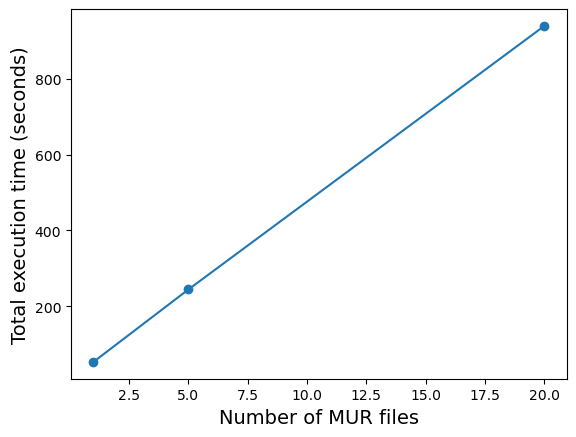

In [20]:
plt.figure()
plt.plot(filenums[:-1], exectimes, 'o-')
plt.xlabel("Number of MUR files", fontsize=14)
plt.ylabel("Total execution time (seconds)", fontsize=14)

Text(0, 0.5, 'Total execution time (minutes)')

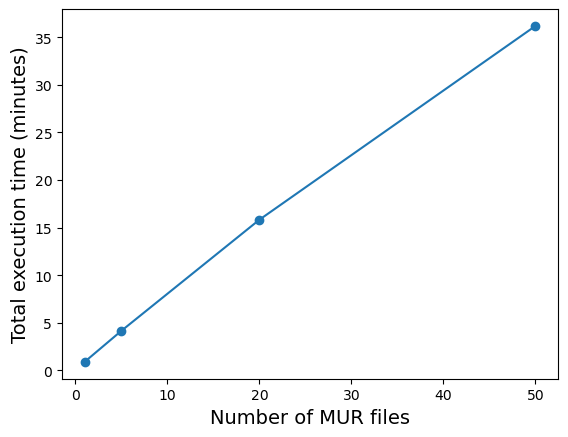

In [8]:
plt.figure()
plt.plot(filenums, np.array([54, 250, 950, 2171])/60, 'o-')
plt.xlabel("Number of MUR files", fontsize=14)
plt.ylabel("Total execution time (minutes)", fontsize=14)

## Conclusions

* t2.large does not have enough RAM to casually open a MUR file and perform basic preprocessing (mask, scale, offset). This is the case using both h5py and xarray.